In [1]:
import numpy as np
from scipy import linalg as la
from scipy.stats import linregress
from matplotlib import pyplot as plt


# Auxiliary Functions ---------------------------------------------------------
def starting_point(A, b, c):
    """Calculate an initial guess to the solution of the linear program
    min c^T x, Ax = b, x>=0.
    Reference: Nocedal and Wright, p. 410.
    """
    # Calculate x, lam, mu of minimal norm satisfying both
    # the primal and dual constraints.
    B = la.inv(A @ A.T)
    x = A.T @ B @ b
    lam = B @ A @ c
    mu = c - (A.T @ lam)

    # Perturb x and s so they are nonnegative.
    dx = max((-3./2)*x.min(), 0)
    dmu = max((-3./2)*mu.min(), 0)
    x += dx*np.ones_like(x)
    mu += dmu*np.ones_like(mu)

    # Perturb x and mu so they are not too small and not too dissimilar.
    dx = .5*(x*mu).sum()/mu.sum()
    dmu = .5*(x*mu).sum()/x.sum()
    x += dx*np.ones_like(x)
    mu += dmu*np.ones_like(mu)

    return x, lam, mu

# Use this linear program generator to test your interior point method.
def randomLP(j,k):
    """Generate a linear program min c^T x s.t. Ax = b, x>=0.
    First generate m feasible constraints, then add
    slack variables to convert it into the above form.
    Parameters:
        j (int >= k): number of desired constraints.
        k (int): dimension of space in which to optimize.
    Returns:
        A ((j, j+k) ndarray): Constraint matrix.
        b ((j,) ndarray): Constraint vector.
        c ((j+k,), ndarray): Objective function with j trailing 0s.
        x ((k,) ndarray): The first 'k' terms of the solution to the LP.
    """
    A = np.random.random((j,k))*20 - 10
    A[A[:,-1]<0] *= -1
    x = np.random.random(k)*10
    b = np.zeros(j)
    b[:k] = A[:k,:] @ x
    b[k:] = A[k:,:] @ x + np.random.random(j-k)*10
    c = np.zeros(j+k)
    c[:k] = A[:k,:].sum(axis=0)/k
    A = np.hstack((A, np.eye(j)))
    return A, b, -c, x


# Problems --------------------------------------------------------------------
def interiorPoint(A, b, c, niter=20, tol=1e-16, verbose=False):
    """Solve the linear program min c^T x, Ax = b, x>=0
    using an Interior Point method.

    Parameters:
        A ((m,n) ndarray): Equality constraint matrix with full row rank.
        b ((m, ) ndarray): Equality constraint vector.
        c ((n, ) ndarray): Linear objective function coefficients.
        niter (int > 0): The maximum number of iterations to execute.
        tol (float > 0): The convergence tolerance.

    Returns:
        x ((n, ) ndarray): The optimal point.
        val (float): The minimum value of the objective function.
    """
    m,n = A.shape
    F = lambda x, lam, mu: np.concatenate((A.T @ lam + mu - c, A@x - b, np.diag(mu) @ x))           #define our function F

    top_rows = np.vstack((np.hstack((np.zeros((n,n)), A.T, np.eye(n))), np.hstack((A, np.zeros((m,m)), np.zeros((m,n))))))    #calculate the top 2 rows of DF only once
    
    def search_d(x, lam, mu):
        dF = np.vstack((top_rows, np.hstack((np.diag(mu), np.zeros((n,m)), np.diag(x)))))       #create dF with our previous top_rows and dynamic input
        f = F(x, lam, mu)         #call our function that generates f

        return la.lu_solve(la.lu_factor(dF), -f + np.insert((np.dot(x, mu) / (10*n))*np.ones(n), 0, np.zeros(n+m)))        #set up the system and solve using lu decomposition

    def step_length(x, mu, delx, delmu):
        neg_mus = delmu < 0                                           #get the del mus that are negative
        alpha = np.min((1, np.min(-mu[neg_mus] / delmu[neg_mus])))    #calculate maximum allowable step lengths

        neg_x = delx < 0
        delta = np.min((1, np.min(-x[neg_x] / delx[neg_x])))           #do the same for the xs

        return np.min((1, .95*alpha)), np.min((1, .95*delta))     #return the final step lengths

    x, lam, mu = starting_point(A, b, c)            #use the given function to find a starting point

    for i in range(niter):
        if x @ mu / n < tol:        #break loop if duality measure is less than tolerance
            break
    
        direct = search_d(x, lam, mu)    #find our step direction
        delx = direct[:n]      #get the delta x's

        dellam = direct[n:n+m]       #get the delta lambdas

        delmu = direct[n+m:]         #get the delta mus

        alpha, delta = step_length(x, mu, delx, delmu)   #calculate the ideal step_length

        x += delta * delx                         #calculate the next points in the iteration
        lam += alpha * dellam
        mu += alpha * delmu

    return x, c@x

def test1():
    def randomLP(j, k):
        """Generate a linear program min c\trp x s.t. Ax = b, x>=0.
        First generate m feasible constraints, then add
        slack variables to convert it into the above form.
        Inputs:
        j (int >= k): number of desired constraints.
        k (int): dimension of space in which to optimize.
        Outputs:
        A ((j, j+k) ndarray): Constraint matrix.
        b ((j,) ndarray): Constraint vector.
        c ((j+k,), ndarray): Objective function with j trailing 0s.
        x ((k,) ndarray): The first 'k' terms of the solution to the LP.
        """
        A = np.random.random((j,k))*20 - 10
        A[A[:,-1]<0] *= -1
        x = np.random.random(k)*10
        b = np.zeros(j)
        b[:k] = A[:k,:] @ x
        b[k:] = A[k:,:] @ x + np.random.random(j-k)*10
        c = np.zeros(j+k)
        c[:k] = A[:k,:].sum(axis=0)/k
        A = np.hstack((A, np.eye(j)))
        return A, b, -c, x

    j, k = 7, 5
    A, b, c, x = randomLP(j, k)
    point, value = interiorPoint(A, b, c)
    return(np.allclose(x, point[:k]))
test1()

True

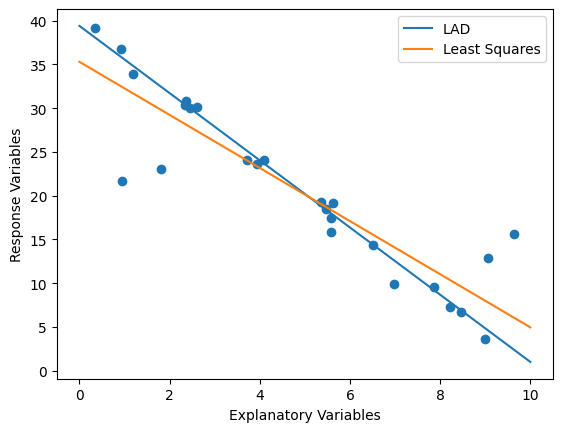

In [2]:
def leastAbsoluteDeviations(filename='simdata.txt'):
    """Generate and show the plot requested in the lab."""
    data = np.loadtxt(filename)          #load the data

    m = data.shape[0]         #use the given code to initialize the vectors
    n = data.shape[1] - 1
    c = np.zeros(3*m + 2*(n + 1))
    c[:m] = 1
    y = np.empty(2*m)
    y[::2] = -data[:, 0]
    y[1::2] = data[:, 0]
    x = data[:, 1:]

    A = np.ones((2*m, 3*m + 2*(n + 1)))      #use the given code to initialize A
    A[::2, :m] = np.eye(m)
    A[1::2, :m] = np.eye(m)
    A[::2, m:m+n] = -x
    A[1::2, m:m+n] = x
    A[::2, m+n:m+2*n] = x
    A[1::2, m+n:m+2*n] = -x
    A[::2, m+2*n] = -1
    A[1::2, m+2*n+1] = -1
    A[:, m+2*n+2:] = -np.eye(2*m, 2*m)
    
    sol = interiorPoint(A, y, c, niter=10)[0]      #calculate solution by calling interior point function
    beta = sol[m:m+n] - sol[m+n:m+2*n]             #extract values of beta and b
    b = sol[m+2*n] - sol[m+2*n+1]

    slope, intercept = linregress(data[:,1], data[:,0])[:2]         #calculate least squares and plot it along with our LAD with the data
    domain = np.linspace(0,10,200)
    plt.scatter(data[:,1],data[:,0])
    plt.plot(domain, beta*domain + b, label="LAD")
    plt.plot(domain, domain*slope + intercept, label="Least Squares")
    plt.legend(loc="upper right")
    plt.xlabel("Explanatory Variables")
    plt.ylabel("Response Variables")
    plt.show()
leastAbsoluteDeviations()